Colorize a blank and white photo stylizing it to resemble another color photo.  
Perform style transfer using Vincent van Gogh's "Starry Night".

using `scikit-image` and `KNeighborsRegressor`

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2lab, lab2rgb
from sklearn.neighbors import KNeighborsRegressor # KNN Regressor
import os

path = 'style_transfer'

How to represent image colors  
Each painting has 256X256 pixels

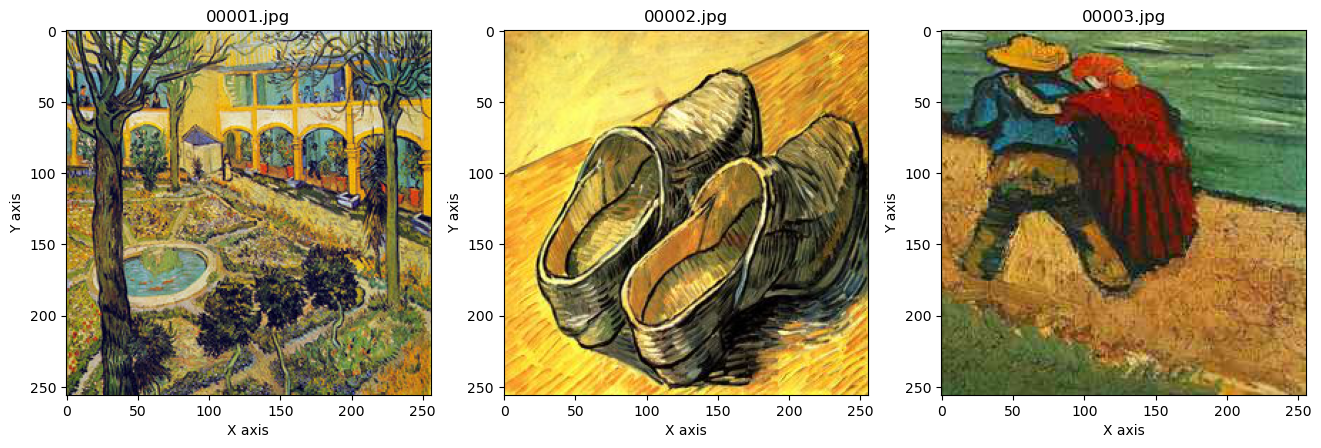

In [4]:
data_dir = os.path.join(path, 'vangogh')
fig = plt.figure(figsize=(16, 5))
for i, file in enumerate(np.sort(os.listdir(data_dir))[:3]):
    img = io.imread(os.path.join(data_dir, file))
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(img)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title(file)
plt.show()

- 确定图像色彩表示方式，建立黑白与彩色之间的颜色映射
- 黑白图像只包含亮度信息，无法直接还原颜色，需要补充信息
- KNN实现黑白到彩色的映射。将风格图像转换为黑白，提取灰度信息
- 将像素进行映射匹配，选择最接近的原始像素取平均

- 改进：
    - 使用$K$个3X3的窗口提取每个像素周围的像素，扩大匹配范围
    - 使用相邻像素的信息能提高准确度
    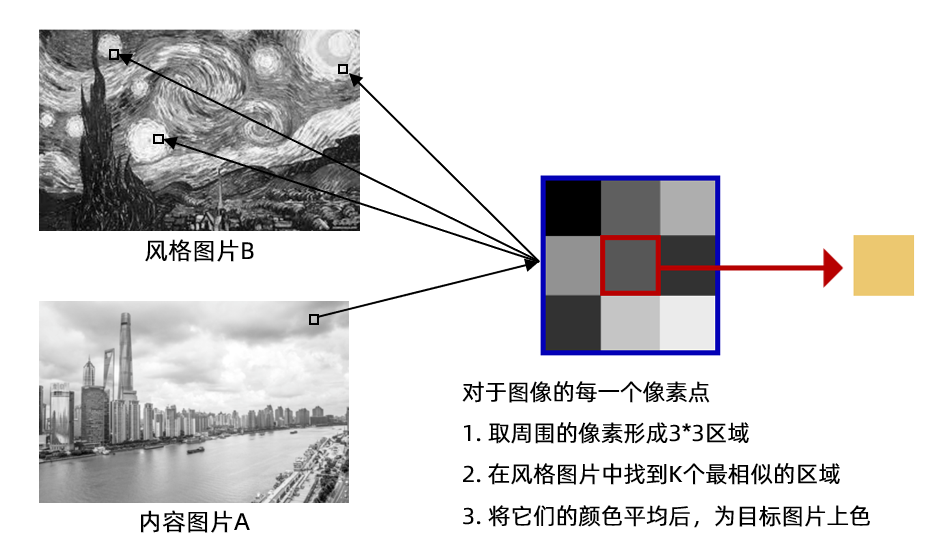

In [10]:
# block_size represents the number of layers that extend outward,
# extending 1 layer by 3*3
block_size = 2

def read_style_image(file_name, size=block_size):
    # read the style image, get mapped X->Y
    # X stores the grayscale value of 3*3-pixel cell, Y stores the color value of a central pixel cell
    # Read the image file, let the width of the image be W, the height be H, get the RGB mateix of W * H * 3
    img = io.imread(file_name)
    fig = plt.figure()
    plt.imshow(img)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()
    
    # Converted RGB to LAB, size is unchanged, L,A,B in three dimensions
    img = rgb2lab(img)
    # get the w and h of the img
    w, h = img.shape[:2]
    
    X = []
    Y = []
    # enumerates all possible centers
    for x in range(size, w - size):
        for y in range(size, h - size):
            # save all windows
            X.append(img[x - size: x + size + 1, 
                        y - size: y + size + 1, 0].flatten())
            # Save the color values A and B for the window
            Y.append(img[x, y, 1:])
    return X, Y

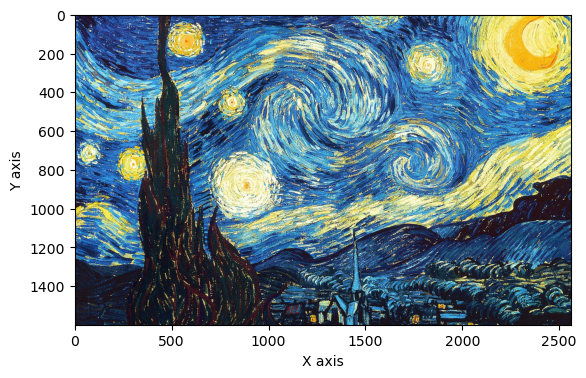

KNeighborsRegressor(n_neighbors=4, weights='distance')

In [11]:
X, Y = read_style_image(os.path.join(path, 'style.jpg')) # Create a new forward

# weight='distance' indicates that the neighbor's weight is inversely
# proportional to its distance from the sample
knn = KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(X, Y)

split the content image into windows of the same size and color it with the KNN model

In [12]:
def rebuild(img, size=block_size):
    # print the content image
    fig = plt.figure()
    plt.imshow(img)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()
    
    # Convert the content image to LAB representation
    img = rgb2lab(img)
    w, h = img.shape[:2]
    
    # Initializes a matrix corresponding to the output image
    photo = np.zeros([w, h, 3])
    # Enumerates the center points of the content image, saving all windows
    print('Constructing window...')
    X = []
    for x in range(size, w - size):
        for y in range(size, h - size):
            # Gets the window corresponding to the center point
            window = img[x - size: x + size + 1, \
                y - size: y + size + 1, 0].flatten()
            X.append(window)
    X = np.array(X)

    # Use KNN regression to predict color
    print('Predicting...')
    pred_ab = knn.predict(X).reshape(w - 2 * size, h - 2 * size, -1)
    # Sets the output image
    photo[:, :, 0] = img[:, :, 0]
    photo[size: w - size, size: h - size, 1:] = pred_ab

    # Because the outermost size layer can not construct the window, 
    # we simply crop the pixels out
    photo = photo[size: w - size, size: h - size, :]
    return photo

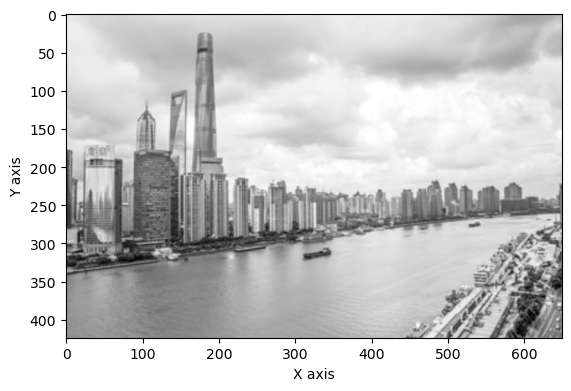

Constructing window...
Predicting...


In [ ]:
content = io.imread(os.path.join(path, 'input.jpg'))
new_photo = rebuild(content)
# 为了展示图像，我们将其再转换为RGB表示
new_photo = lab2rgb(new_photo)

fig = plt.figure()
plt.imshow(new_photo)
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()